# ДТЗ Гришин Алексей ПМ18-4

## Импорт библиотек

In [379]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')



from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso,SGDRegressor 
from sklearn.metrics import silhouette_score,mean_squared_error
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.manifold import TSNE


import time
from bs4 import BeautifulSoup
from functools import reduce
import requests

## Начальные данные

In [380]:
base_link = 'https://www.cian.ru/cat.php?deal_type=sale&district%5B0%5D=4&engine_version=2&offer_type=flat&p='
n_pages = 50
pages = [i for i in range(n_pages)]

## Парсинг данных сайта ЦИАН о квартирах и аппартаментах ЦАО Москвы

In [381]:
def parse_page(pages = pages):
    flat_links = []
    
    for i in range(len(pages)):
        link = str(base_link + str(i+1))
        page_text = requests.get(link).text
        soup = BeautifulSoup(page_text)
        for link in soup.find_all('a', class_ = '_93444fe79c--link--39cNw'):
            flat_links.append(link.get('href'))
            
    return flat_links

def parse_flat(links):
    prices = []
    squares = []
    undergrounds = []
    distances = []
    address = []
    flat_types = []
    rooms = []
    fl = []
    
    for flat in links:
        flat_temp = requests.get(flat).text
        flat_soup = BeautifulSoup(flat_temp)
        
        try:
            prices.append(flat_soup.find('span', class_ = 'a10a3f92e9--price_value--1iPpd').text)
        except:
            prices.append(np.nan)
        
        try:
            squares.append(flat_soup.find('div', class_ = 'a10a3f92e9--info-value--18c8R').text)
        except:
            squares.append(np.nan)
        
        try:
            undergrounds.append(flat_soup.find('a', class_ = 'a10a3f92e9--underground_link--AzxRC').text)
        except:
            undergrounds.append(np.nan)
        
        try:    
            distances.append(flat_soup.find('span', class_ = 'a10a3f92e9--underground_time--1fKft').text)
        except:
            distances.append(np.nan)
        
        try:
            address.append(flat_soup.find('address', class_ = 'a10a3f92e9--address--140Ec').text)
        except:
            address.append(np.nan)
         
        try:
            flat_types.append(flat_soup.find('span', class_ = 'a10a3f92e9--value--3Ftu5').text)
        except:
            flat_types.append(np.nan)
        
        try:
            rooms.append(flat_soup.find('h1', class_ = 'a10a3f92e9--title--2Widg').text.split(',')[0])
        except:
            rooms.append(np.nan)
        
        try:
            fl.append(flat)
        except:
            fl.append(np.nan)
        
    flat_data = pd.DataFrame({'address':address,
                              'price':prices,
                              'squares':squares,
                              'underground':undergrounds,
                              'distance':distances,
                              'flat type':flat_types,
                              'rooms':rooms,
                             'flat link':fl})
    return flat_data

In [382]:
%%time
data = parse_flat(links = parse_page())
data.to_csv('parse_data.csv') # сохранение результатов парсинга

Wall time: 31min 19s


In [383]:
data

,address,price,squares,underground,distance,flat type,rooms,flat link
0,"Москва, ЦАО, р-н Мещанский, Цветной бул., 32АН...",120 204 000 ₽,"143,1 м²",Цветной бульвар,⋅ 3 мин. пешком,Новостройка Апартаменты,4-комн. апартаменты,https://www.cian.ru/sale/flat/238116652/
1,"Москва, ЦАО, р-н Тверской, ул. Палиха, 4На карте",32 784 600 ₽,"60,6 м²",Менделеевская,⋅ 2 мин. пешком,Новостройка Апартаменты,1-комн. апартаменты,https://www.cian.ru/sale/flat/247916409/
2,"Москва, ЦАО, р-н Пресненский, 1-й Красногварде...",39 499 000 ₽,"83,5 м²",Международная,⋅ 5 мин. пешком,Вторичка Апартаменты,3-комн. апартаменты,https://www.cian.ru/sale/flat/240326786/
3,"Москва, ЦАО, р-н Мещанский, Протопоповский пер...",45 999 900 ₽,107 м²,Проспект Мира,⋅ 3 мин. пешком,Вторичка,3-комн. квартира,https://www.cian.ru/sale/flat/245291458/
4,"Москва, ЦАО, р-н Пресненский, Краснопресненска...",89 810 313 ₽,"104,01 м²",Выставочная,⋅ 7 мин. пешком,Новостройка,3-комн. квартира,https://www.cian.ru/sale/flat/244134279/
...,...,...,...,...,...,...,...,...
1395,"Москва, ЦАО, р-н Таганский, Новорогожская ул.,...",11 900 000 ₽,38 м²,Римская,⋅ 8 мин. пешком,Вторичка,1-комн. квартира,https://www.cian.ru/sale/flat/247637820/
1396,"Москва, ЦАО, р-н Красносельский, Скорняжный пе...",12 000 000 ₽,"34,9 м²",Красные ворота,⋅ 10 мин. пешком,Вторичка,1-комн. квартира,https://www.cian.ru/sale/flat/244209133/
1397,"Москва, ЦАО, р-н Басманный, пер. Токмаков, 3-5...",12 000 000 ₽,41 м²,Бауманская,⋅ 10 мин. пешком,Вторичка,2-комн. квартира,https://www.cian.ru/sale/flat/248622063/
1398,"Москва, ЦАО, р-н Басманный, пер. Токмаков, 3-5...",12 300 000 ₽,40 м²,Бауманская,NaN,Вторичка,2-комн. квартира,https://www.cian.ru/sale/flat/248645293/


## Очистка и форматирование данных 

In [384]:
data = data.dropna()
data = data.reset_index()
data = data.drop('index',axis = 1)


data['squares'] = [float(data['squares'][i].split()[0].replace(",",'.')) for i in range(len(data['squares']))]

data['price'] = [data['price'][i].split('₽')[0] for i in range(len(data['price']))]
data['price'] = [int(reduce(lambda x,y: x + y,data['price'][i].split())) for i in range(len(data['price']))]

data['district'] = [data['address'][i].split(',')[2] for i in range(len(data['address']))]

data['distance'] = [data['distance'][i].split('мин')[0][4:6] for i in range(len(data['distance']))]
data['distance'] = data['distance'].replace({'<1':'1'})
data['distance'] = [int(data['distance'][i]) for i in range(len(data['distance']))]

data['address'] = [data['address'][i].split('На карте')[0] for i in range(len(data['address']))]


data['rooms'] = data['rooms'].replace(
    ['Апартаменты свободной планировки','Апартаменты-студия','Студия','Квартира свободной планировки','Многокомнатная квартира','Многокомнатные апартаменты'],
    ['1-комн. апартаменты','1-комн. апартаменты','1-комн. квартира','2-комн. квартира','3-комн. квартира','3-комн. апартаменты'])
data['property type'] = [data['rooms'][i].split('.')[1] for i in range(len(data['rooms'])) ]
data['rooms'] = [int(data['rooms'][i][0]) for i in range(len(data['rooms'])) ]

In [385]:
data

,address,price,squares,underground,distance,flat type,rooms,flat link,district,property type
0,"Москва, ЦАО, р-н Мещанский, Цветной бул., 32А",120204000,143.10,Цветной бульвар,3,Новостройка Апартаменты,4,https://www.cian.ru/sale/flat/238116652/,р-н Мещанский,апартаменты
1,"Москва, ЦАО, р-н Тверской, ул. Палиха, 4",32784600,60.60,Менделеевская,2,Новостройка Апартаменты,1,https://www.cian.ru/sale/flat/247916409/,р-н Тверской,апартаменты
2,"Москва, ЦАО, р-н Пресненский, 1-й Красногварде...",39499000,83.50,Международная,5,Вторичка Апартаменты,3,https://www.cian.ru/sale/flat/240326786/,р-н Пресненский,апартаменты
3,"Москва, ЦАО, р-н Мещанский, Протопоповский пер...",45999900,107.00,Проспект Мира,3,Вторичка,3,https://www.cian.ru/sale/flat/245291458/,р-н Мещанский,квартира
4,"Москва, ЦАО, р-н Пресненский, Краснопресненска...",89810313,104.01,Выставочная,7,Новостройка,3,https://www.cian.ru/sale/flat/244134279/,р-н Пресненский,квартира
...,...,...,...,...,...,...,...,...,...,...
1167,"Москва, ЦАО, р-н Пресненский, ул. Заморенова, 9С2",11800000,34.20,Краснопресненская,5,Вторичка,1,https://www.cian.ru/sale/flat/244034652/,р-н Пресненский,квартира
1168,"Москва, ЦАО, р-н Таганский, Новорогожская ул.,...",11900000,38.00,Римская,8,Вторичка,1,https://www.cian.ru/sale/flat/247637820/,р-н Таганский,квартира
1169,"Москва, ЦАО, р-н Красносельский, Скорняжный пе...",12000000,34.90,Красные ворота,10,Вторичка,1,https://www.cian.ru/sale/flat/244209133/,р-н Красносельский,квартира
1170,"Москва, ЦАО, р-н Басманный, пер. Токмаков, 3-5",12000000,41.00,Бауманская,10,Вторичка,2,https://www.cian.ru/sale/flat/248622063/,р-н Басманный,квартира


In [386]:
data.to_csv('edited_data.csv')

## Визуализация и анализ данных

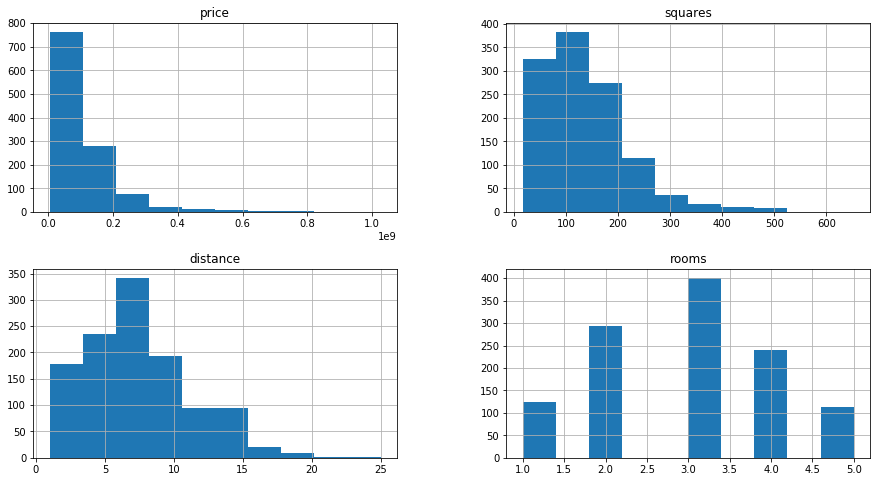

In [387]:
data.hist()
fig = plt.gcf()
fig.set_size_inches(15,8)


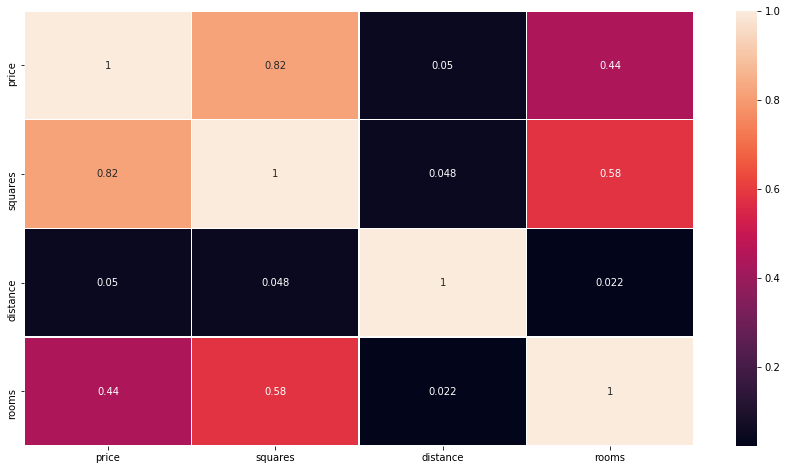

In [388]:
sns.heatmap(data.corr(),annot = True, linewidths = 0.2)
fig = plt.gcf()
fig.set_size_inches(15,8)

Text(0.5, 1.0, 'Диаграмма рассеивания цен и метража квартир ЦАО')

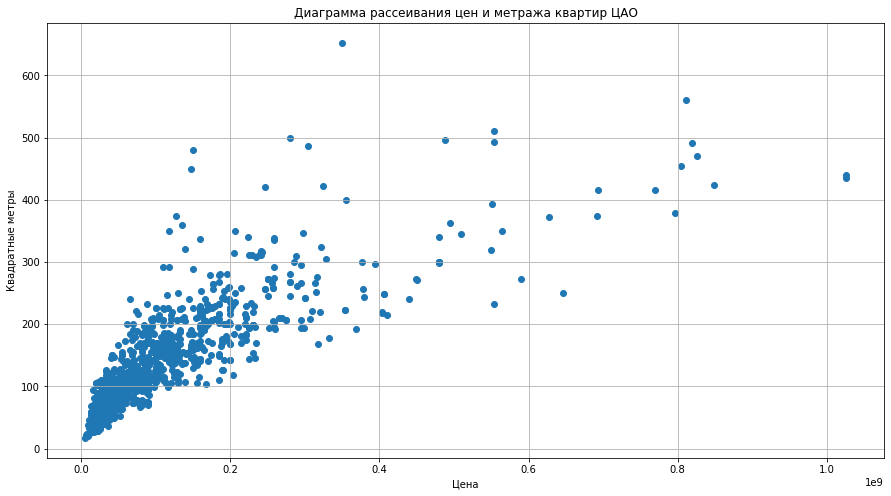

In [389]:
plt.scatter('price','squares', data = data)
fig = plt.gcf()
fig.set_size_inches(15,8)
plt.ylabel('Квадратные метры')
plt.xlabel('Цена')
plt.grid()
plt.title('Диаграмма рассеивания цен и метража квартир ЦАО')

## Перевод категориальных данных

In [390]:
X = data.drop(['address','flat link'],axis = 1)

In [391]:
X['property type'] = X['property type'].map({' апартаменты':0,' квартира':1})

In [392]:
X

,price,squares,underground,distance,flat type,rooms,district,property type
0,120204000,143.10,Цветной бульвар,3,Новостройка Апартаменты,4,р-н Мещанский,0
1,32784600,60.60,Менделеевская,2,Новостройка Апартаменты,1,р-н Тверской,0
2,39499000,83.50,Международная,5,Вторичка Апартаменты,3,р-н Пресненский,0
3,45999900,107.00,Проспект Мира,3,Вторичка,3,р-н Мещанский,1
4,89810313,104.01,Выставочная,7,Новостройка,3,р-н Пресненский,1
...,...,...,...,...,...,...,...,...
1167,11800000,34.20,Краснопресненская,5,Вторичка,1,р-н Пресненский,1
1168,11900000,38.00,Римская,8,Вторичка,1,р-н Таганский,1
1169,12000000,34.90,Красные ворота,10,Вторичка,1,р-н Красносельский,1
1170,12000000,41.00,Бауманская,10,Вторичка,2,р-н Басманный,1


In [393]:
oe = OneHotEncoder(sparse = False)
categorical_columns = [column for column in X.columns if X[column].dtype == 'object']
encoded_cat_columns = pd.DataFrame(oe.fit_transform(X[categorical_columns]))
X = pd.concat([encoded_cat_columns, X], axis = 1)

In [394]:
X = X.drop(['underground','flat type', 'district'],axis = 1)

## Масштабирование данных и понижение размерности

In [395]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_embedded = TSNE(n_components=2, random_state = 22).fit_transform(X)

In [396]:
X_train,X_test = train_test_split(X_embedded,random_state = 7, test_size = .2)

## Дендрограмма 

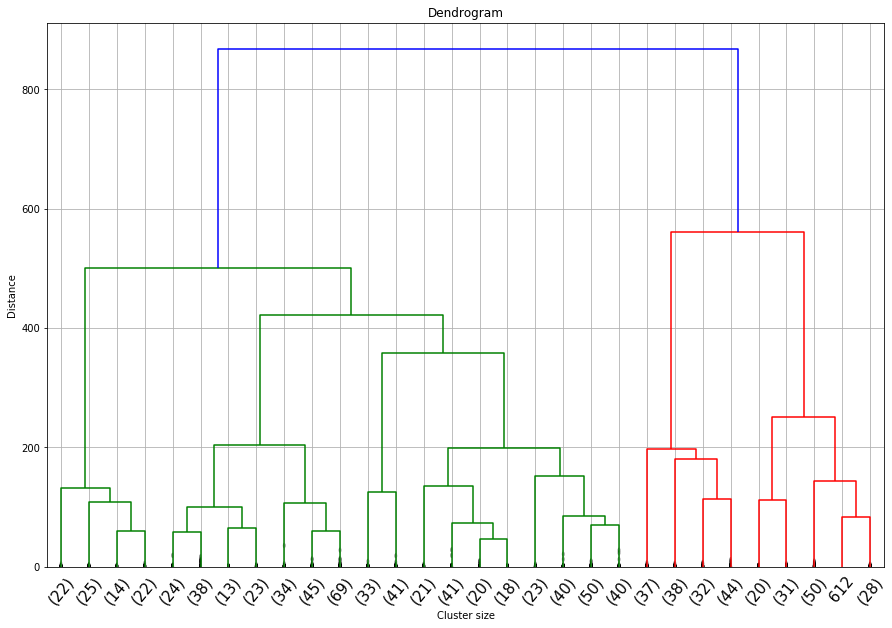

In [397]:
Z  = linkage(X_train,'ward')
dendrogram(Z, truncate_mode = 'lastp', leaf_rotation = 50. , leaf_font_size = 15., show_contracted = True)

plt.title('Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.grid()
fig = plt.gcf()
fig.set_size_inches(15,10)

## Метод локтя для оценки числа кластеров

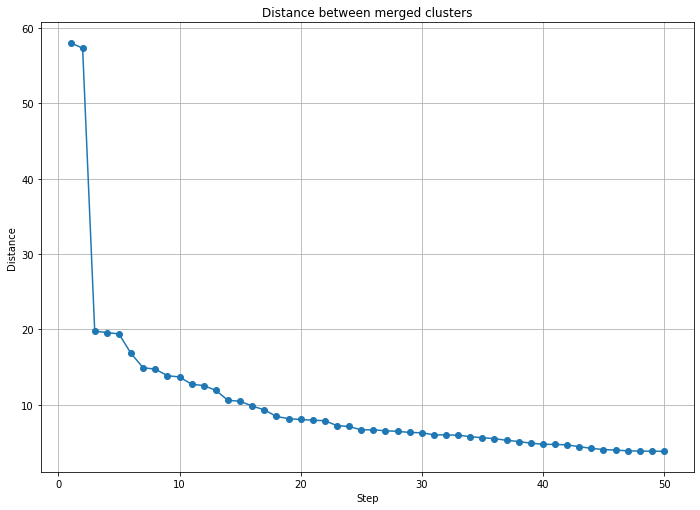

In [398]:
link = linkage(X_embedded)
dist = link[-50:, 2]
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Distance between merged clusters')
plt.xlabel('Step')
plt.ylabel('Distance')
plt.grid()


## Кластеризация 

In [399]:
model = KMeans(n_clusters = 4).fit(X_train)
clusters = model.predict(X_test)

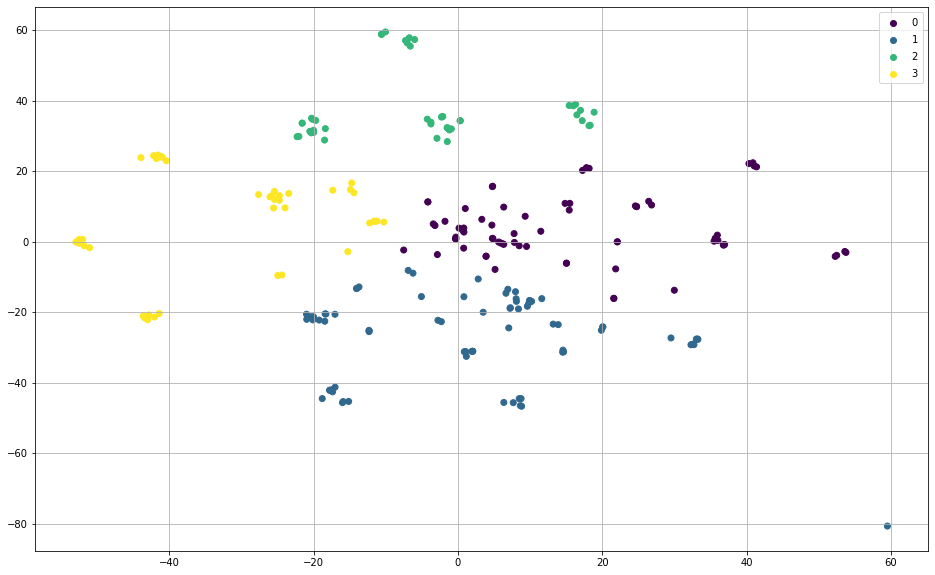

In [400]:
fig = plt.gcf()
fig.set_size_inches(16,10)
p = plt.scatter( x = [x[0] for x in X_test],y =[x[1] for x in X_test],  c = clusters, label = clusters)
a = p.legend_elements(prop = 'colors')
plt.grid()
plt.legend(*a)

In [401]:
y = data['price']
X = data.drop(['price','flat link','address'], axis = 1)
X['property type'] = X['property type'].map({' апартаменты':0,' квартира':1})
oe = OneHotEncoder(sparse = False)
categorical_columns = [column for column in X.columns if X[column].dtype == 'object']
encoded_cat_columns = pd.DataFrame(oe.fit_transform(X[categorical_columns]))
X = pd.concat([encoded_cat_columns, X], axis = 1)
X = X.drop(['underground','flat type', 'district'],axis = 1)
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 7, test_size = .2)

## Регрессия 

In [402]:
models = [Lasso(),Ridge(),KNeighborsRegressor(),DecisionTreeRegressor(),SGDRegressor()]
dt = []
RMSE = []
rs = []
for model in models:
    t1 = time.time()
    model.fit(X_train,y_train)
    t2 = time.time()
    y_pred = model.predict(X_test)
    dt.append( t2 - t1)
    
    
    RMSE.append(mean_squared_error(y_test,y_pred)**0.5)
    rs.append(model.score(X_test,y_test))
    
models = [str(model).split('(')[0] for model in models]   
results = pd.DataFrame({'model': models,'R^2':rs,'RMSE':RMSE,'Fit time':dt})
models_results = pd.DataFrame(results)

In [403]:
models_results

,model,R^2,RMSE,Fit time
0,Lasso,0.596853,6.975750e+07,0.082775
1,Ridge,0.597994,6.965874e+07,0.002991
2,KNeighborsRegressor,0.538974,7.459709e+07,0.021940
3,DecisionTreeRegressor,0.158567,1.007788e+08,0.011966
4,SGDRegressor,0.601416,6.936165e+07,0.012964


# Улучшение модели

In [404]:
gridmodel = Ridge()
params = {'alpha': [i/100 for i in range(100)]}


searchpar = GridSearchCV(gridmodel, params, n_jobs = -1)

searchpar.fit(X_train,y_train)
searchpar.best_params_

{'alpha': 0.99}

In [405]:
model = Ridge(alpha = 0.99).fit(X_train,y_train)

y_pred = model.predict(X_test)

print('R^2 : ', model.score(X_test,y_test))
print('RMSE: ', mean_squared_error(y_test,y_pred)**0.5)

R^2 :  0.5979832872083125
RMSE:  69659651.08217302


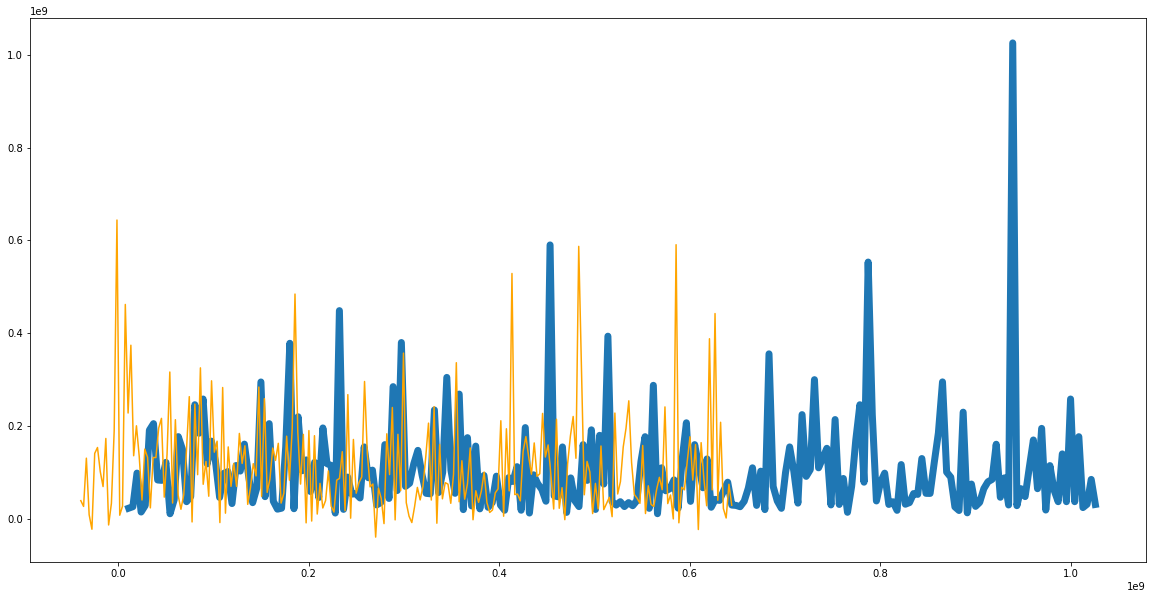

In [406]:
plt.figure(figsize=(20,10))
plt.plot(np.linspace(min(y_test),max(y_test),len(y_test)),y_test , linewidth = 7)
plt.plot(np.linspace(min(y_pred),max(y_pred),len(y_pred)),y_pred , color = 'orange')